## 内容索引
1. 相关性分析 --- cov函数、diagonal函数、trace函数、corrcoef函数
2. 多项式拟合 --- polyfit函数、polyval函数、roots函数、polyder函数
3. 计算净额成交量 --- sign函数、piecewise函数
4. 模拟交易过程 --- vectorize函数、round函数
5. 数据平滑 --- hanning函数

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import plot
from matplotlib.pyplot import show

## 1. 股票相关性分析
本例子中， 我们使用2个示例数据集提供收盘价数据，第一家公司是BHP Billiton(BHP)，其主要业务是石油、金属和钻石开采；第二家公司是Vale(VALE)，也是一家金属开采业公司，他们有部分业务是重合的。我们来分析一下他们的股票相关性。

In [2]:
# 首先读入两只股票的收盘价，并计算收益率
bhp_cp = np.loadtxt('BHP.csv', delimiter=',', usecols=(6,), unpack=True)
vale_cp = np.loadtxt('VALE.csv', delimiter=',', usecols=(6,), unpack=True)
bhp_returns = np.diff(bhp_cp) / bhp_cp[:-1]
vale_returns = np.diff(vale_cp) / vale_cp[:-1]

协方差描述的是两个变量共同变化的趋势，其实就是归一化前的相关系数。
使用cov函数计算**股票收益率的协方差矩阵**

In [3]:
covariance = np.cov(bhp_returns, vale_returns)
print('Covariance:\n', covariance) 

Covariance:
 [[ 0.00028179  0.00019766]
 [ 0.00019766  0.00030123]]


In [4]:
# 查看协方差矩阵对角线的元素
print('Covariance diagonal:\n', covariance.diagonal()) 
# 计算矩阵的迹，即对角线之和
print('Covariance trace:\n', covariance.trace()) 
# 计算相关系数，相关系数是协方差除以各自标准差的乘积
print('Correlation coefficient:\n', covariance / (bhp_returns.std() * vale_returns.std())) 

Covariance diagonal:
 [ 0.00028179  0.00030123]
Covariance trace:
 0.00058302354992
Correlation coefficient:
 [[ 1.00173366  0.70264666]
 [ 0.70264666  1.0708476 ]]


用相关系数来度量两只股票的相关程度。相关系数的取值范围在-1到1之间，一组数据域自身的相关系数为1.使用corrcoef函数计算相关系数。

In [5]:
# 使用corrcoef计算更加精确
print('Correlation coefficient:\n', np.corrcoef(bhp_returns, vale_returns)) 

Correlation coefficient:
 [[ 1.          0.67841747]
 [ 0.67841747  1.        ]]


相关系数矩阵关于对角线对称，BHP与VALE的相关系数等于VALE和BHP的相关系数。看起来0.68的相关系数表示他们的相关程度似乎不是很强。

### 判断两只股票的价格走势是否同步
如果它们的差值偏离了平均差值2倍于标准差的距离，则认为他们走势不同步

In [6]:
difference = bhp_cp - vale_cp
avg = np.mean(difference)
dev = np.std(difference)
# 检查最后一次收盘价是否在同步状态
print("Out of sync : ", np.abs(difference[-1] - avg) > 2*dev) 

Out of sync :  False


这说明，最后一次收盘价不再同步状态，我们暂时不能进行交易

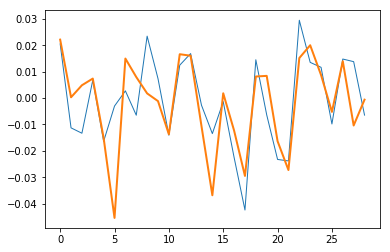

In [7]:
# 绘制收益率曲线
t = np.arange(len(bhp_returns))
plot(t, bhp_returns, lw=1)
plot(t, vale_returns, lw=2)
show()

## 2. 多项式拟合
NumPy中的plotfit函数可以用多项式去拟合一系列数据点，无论这些数据点是否来自连续函数都适用。

In [8]:
# 用三次多项式去拟合两只股票收盘价的差价
t = np.arange(len(bhp_cp))
poly = np.polyfit(t, bhp_cp-vale_cp, 3)
print("Polynomial fit\n", poly) 

Polynomial fit
 [  1.11655581e-03  -5.28581762e-02   5.80684638e-01   5.79791202e+01]


In [9]:
# 用刚才得到的多项式对象，推断下一个值
print("Next value: ", np.polyval(poly, t[-1]+1)) 

Next value:  57.9743076081


理想情况下，BHP和VALE股票收盘价的差价越小越好。在极限情况下，差值可以在某个点为0。用roots函数找到拟合多项式函数在什么时候达到0。

In [10]:
print("Roots: ", np.roots(poly)) 

Roots:  [ 35.48624287+30.62717062j  35.48624287-30.62717062j -23.63210575 +0.j        ]


### 求极值

In [11]:
# 极值位于导数为0的点
der = np.polyder(poly)
print("Dervative:\n", der) 
# 得到多项式导函数的系数

Dervative:
 [ 0.00334967 -0.10571635  0.58068464]


In [12]:
# 求出导函数的根，即找出原多项式函数的极值点
print("Extremas: ", np.roots(der)) 

Extremas:  [ 24.47820054   7.08205278]


In [13]:
# 通过argmax和argmin函数找到最大最小值点来检查结果
vals = np.polyval(poly, t)
print("Maximum index: ", np.argmax(vals)) 
print("Minimum index: ", np.argmin(vals)) 

Maximum index:  7
Minimum index:  24


### 绘制拟合曲线

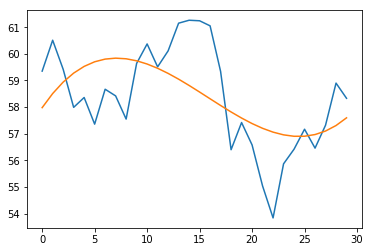

In [14]:
plot(t, bhp_cp-vale_cp)
plot(t, vals)
show()

## 3. 计算净额成交量
成交量表示价格波动的大小，净额成交量（On-Balance Volume)是由当日收盘价、前一天的收盘价以及当日成交量计算得出的。

以前一日为基期计算当日的OBV的值（可认为基期的OBV的值为0）。若当日收盘价高于前一日收盘价，则本日OBV等于基期OBV加上当日成交量，否则减去当日成交量。

**我们需要在成交量前面乘上一个有收盘价变化决定的正负号。**

In [15]:
cp, volume = np.loadtxt('BHP.csv', delimiter=',', usecols=(6,7), unpack=True)
change = np.diff(cp)
print("Change:", change) 

Change: [ 1.92 -1.08 -1.26  0.63 -1.54 -0.28  0.25 -0.6   2.15  0.69 -1.33  1.16
  1.59 -0.26 -1.29 -0.13 -2.12 -3.91  1.28 -0.57 -2.07 -2.07  2.5   1.18
  1.03 -0.88  1.31  1.24 -0.59]


使用NumPy的sign函数返回每个元素的正负号。

In [16]:
signs = np.sign(change)
print("Signs:\n", signs) 

Signs:
 [ 1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.
  1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1.]


使用Numpy的piecewise函数获取数组元素的正负。piecewise(分段)，可以根据给定取值，得到分段。

In [17]:
pieces = np.piecewise(change, [change<0, change>0], [-1,1])
print("Pieces:\n", pieces) 

Pieces:
 [ 1. -1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.
  1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1.]


In [18]:
# 检查两次输出是否一致
print("Arrays equal:", np.array_equal(signs, pieces)) 

Arrays equal: True


In [19]:
# OBV值的计算依赖于前一日的收盘价
print("On balance volume: \n", volume[1:]*signs) 

On balance volume: 
 [ 2620800. -2461300. -3270900.  2650200. -4667300. -5359800.  7768400.
 -4799100.  3448300.  4719800. -3898900.  3727700.  3379400. -2463900.
 -3590900. -3805000. -3271700. -5507800.  2996800. -3434800. -5008300.
 -7809799.  3947100.  3809700.  3098200. -3500200.  4285600.  3918800.
 -3632200.]


## 4. 模拟交易过程

使用vectorize函数可以减少你的程序中使用循环的次数，NumPy中的vectorize函数相当于Python中的map函数。我们用它来计算单个交易日的利润。

In [20]:
# 读入数据
# op is opening price,hp is the highest price
# lp is the lowest price, cp is closing price
op, hp, lp, cp = np.loadtxt('BHP.csv', delimiter=',', usecols=(3,4,5,6), unpack=True)

我们尝试以比开盘价稍低一点的价格买入股票。如果这个价格不在当日的股价范围内，则尝试买入失败，没有获利，也没有亏损，我们返回0。否则，我们将以当日收盘价卖出，所获得的利润即买入卖出的差价。

In [21]:
def calc_profit(op, high, low, close):
    # 以开盘价买入,这里不考虑买入多少股
    buy = op
    
    if low < buy < high:
        return (close-buy) / buy
    else:
        return 0

In [22]:
# 矢量化一个函数，这样可以避免使用循环
func = np.vectorize(calc_profit)
profits = func(op, hp, lp, cp)
print('Profits:\n', profits) 

Profits:
 [ 0.00655139  0.01131437  0.00116464  0.00679832  0.01381543  0.00054148
 -0.01105862  0.00467747 -0.00714131  0.00459991 -0.00221496 -0.01872699
  0.00575141  0.0012513  -0.00374532 -0.02113771  0.00661545 -0.00774693
 -0.00775281  0.01529918  0.00964047  0.02802081 -0.01656818  0.00068713
 -0.01083436 -0.00599135 -0.00882682  0.005024    0.00440238  0.00276488]


In [23]:
# 我们选择非零利润的交易日并计算平均值
real_trades = profits[profits != 0]
print('Number of trades:\n', len(real_trades), round(100.0 * len(real_trades)/len(cp), 2),"%") 
print("Average profit/loss % :", round(np.mean(real_trades) * 100, 2)) 

Number of trades:
 30 100.0 %
Average profit/loss % : 0.02


In [24]:
# 选择正盈利的交易日并计算平均利润
winning_trades = profits[profits > 0]
print("Number of winning trades", len(winning_trades), round(100.0*len(winning_trades)/len(cp),2),"%") 
print("Average profit %", round(np.mean(winning_trades) *100, 2)) 

Number of winning trades 18 60.0 %
Average profit % 0.72


In [25]:
# 选择负盈利的交易日并计算平均损失
losing_trades = profits[profits < 0]
print("Number of winning trades", len(losing_trades), round(100.0*len(losing_trades)/len(cp),2),"%") 
print("Average profit %", round(np.mean(losing_trades) *100, 2)) 

Number of winning trades 12 40.0 %
Average profit % -1.01


## 5. 数据平滑
噪声数据往往很难处理，我们需要对其进行平滑处理。

hanning函数式一个加权余弦的窗函数，我们使用hanning函数平滑股票收益率的数组。

离散卷积运算函数convolve的文档[convolve函数文档](http://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html#numpy.convolve)

In [26]:
# 调用hanning函数计算权重，生成一个长度为N的窗
# 这里N为8
N = 8
weights = np.hanning(N)
print("Weights:\n", weights) 

Weights:
 [ 0.          0.1882551   0.61126047  0.95048443  0.95048443  0.61126047
  0.1882551   0.        ]


In [27]:
# 首先读入两只股票的收盘价，并计算收益率
bhp_cp = np.loadtxt('BHP.csv', delimiter=',', usecols=(6,), unpack=True)
vale_cp = np.loadtxt('VALE.csv', delimiter=',', usecols=(6,), unpack=True)
bhp_returns = np.diff(bhp_cp) / bhp_cp[:-1]
vale_returns = np.diff(vale_cp) / vale_cp[:-1]

# convolve函数，离散线性卷积运算
smooth_bhp = np.convolve(weights/weights.sum(), bhp_returns)[N-1 : -N+1]
smooth_vale = np.convolve(weights/weights.sum(), vale_returns)[N-1 : -N+1]

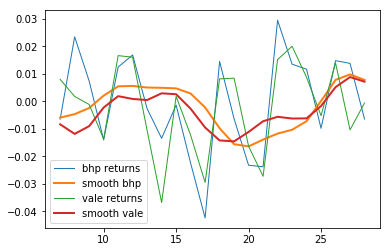

In [28]:
from matplotlib.pyplot import legend

t = np.arange(N-1, len(bhp_returns))
plot(t, bhp_returns[N-1:], lw=1.0, label='bhp returns')
plot(t, smooth_bhp, lw=2.0, label='smooth bhp')
plot(t, vale_returns[N-1:], lw=1.0, label='vale returns')
plot(t, smooth_vale, lw=2.0, label='smooth vale')
legend(loc='best')
show()

图中折线有交叉，这些**交叉点可能是股价趋势的转折点**，至少可以表明BHP和VALE之间的股价关系发生了变化。这些转折点可能会经常出现，我们可以利用他们预测未来的股价走势。

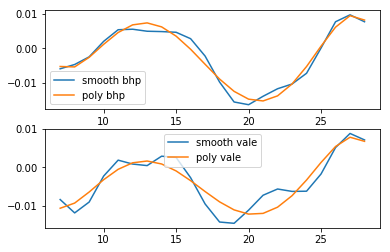

In [29]:
import matplotlib.pyplot as plt

# 使用多项式拟合平滑后的数据
K = 5
t = np.arange(N-1, len(bhp_returns))
poly_bhp = np.polyfit(t, smooth_bhp, K)
poly_vale = np.polyfit(t, smooth_vale, K)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.plot(t, smooth_bhp, label="smooth bhp")
poly_bhp_value = np.polyval(poly_bhp, t)
ax1.plot(t, poly_bhp_value, label='poly bhp')
plt.legend()

ax2 = fig.add_subplot(212)
ax2.plot(t, smooth_vale, label="smooth vale")
poly_vale_value = np.polyval(poly_vale, t)
ax2.plot(t, poly_vale_value, label='poly vale')
plt.legend()
show()

In [30]:
# 得到交叉点的x坐标
# 通过求多项式函数差，再求根
poly_sub = np.polysub(poly_bhp, poly_vale)
xpoints = np.roots(poly_sub)
print("Intersection points:", xpoints) 

Intersection points: [ 28.77520493+0.j          25.42365070+0.j          18.03997643+0.j
   7.88070929+2.42429295j   7.88070929-2.42429295j]


In [33]:
# 判断是否为实数
# select选出实数
reals = np.isreal(xpoints)
print("Real number:",reals) 

xpoints = np.select([reals], [xpoints])
xpoints = xpoints.real
print("Real intersection points:", xpoints) 

Real number: [ True  True  True  True  True]
Real intersection points: [ 28.77520493  25.4236507   18.03997643   0.           0.        ]


In [34]:
# 去除0元素
# trim_zeros函数可以去掉一维数组中开头和末尾为0的元素
print("Sans 0s", np.trim_zeros(xpoints)) 

Sans 0s [ 28.77520493  25.4236507   18.03997643]
